In [16]:
from IPython.display import display, HTML, Javascript
from google.colab import output
import base64

RECORD_SECONDS = 6

display(HTML('''
<button id="recordBtn" style="
    padding:10px 20px;
    font-size:16px;
    background-color:#4CAF50;
    color:white;
    border:none;
    border-radius:8px;
    cursor:pointer;">
    🎤 Démarrer l'enregistrement
</button>
<p id="status"></p>
'''))

display(Javascript(f"""
document.getElementById("recordBtn").onclick = async function() {{

  const status = document.getElementById("status");
  status.innerText = "⏳ Enregistrement en cours...";

  const stream = await navigator.mediaDevices.getUserMedia({{audio:true}});
  const recorder = new MediaRecorder(stream);
  let chunks = [];

  recorder.ondataavailable = e => chunks.push(e.data);
  recorder.start();

  setTimeout(() => recorder.stop(), {RECORD_SECONDS * 1000});

  recorder.onstop = async () => {{
    const blob = new Blob(chunks);
    const arrayBuffer = await blob.arrayBuffer();
    const base64String = btoa(
      String.fromCharCode(...new Uint8Array(arrayBuffer))
    );

    status.innerText = "✅ Terminé !";

    google.colab.kernel.invokeFunction(
      "notebook.save_audio",
      [base64String],
      {{}}
    );
  }};
}};
"""))

def save_audio(b64):
    with open("ma_voix.wav","wb") as f:
        f.write(base64.b64decode(b64))
    print("✅ Audio sauvegardé")

output.register_callback("notebook.save_audio", save_audio)

<IPython.core.display.Javascript object>

✅ Audio sauvegardé


In [17]:
import IPython.display as ipd
ipd.Audio("ma_voix.wav")


/tmp/ipython-input-2850448991.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load("ma_voix.wav", sr=None)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


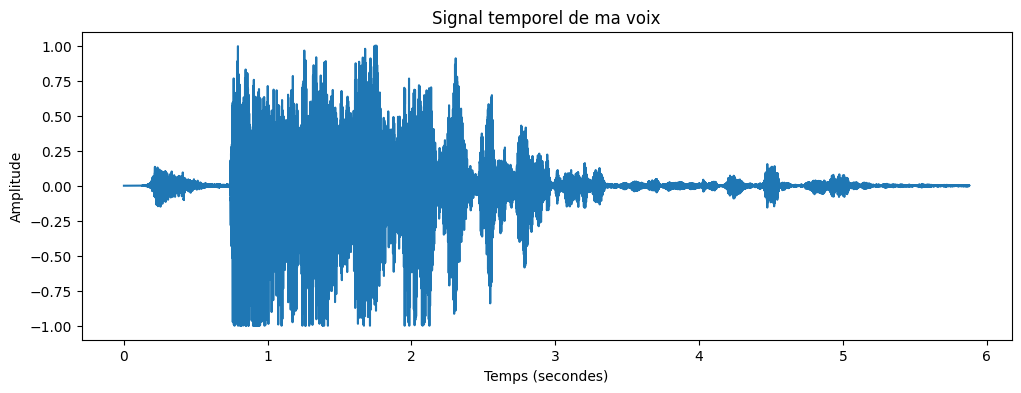

Fréquence d'échantillonnage : 48000 Hz


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Charger ton audio
signal, sr = librosa.load("ma_voix.wav", sr=None)

# Axe temporel
temps = np.linspace(0, len(signal)/sr, len(signal))

plt.figure(figsize=(12,4))
plt.plot(temps, signal)
plt.title("Signal temporel de ma voix")
plt.xlabel("Temps (secondes)")
plt.ylabel("Amplitude")
plt.show()

print("Fréquence d'échantillonnage :", sr, "Hz")

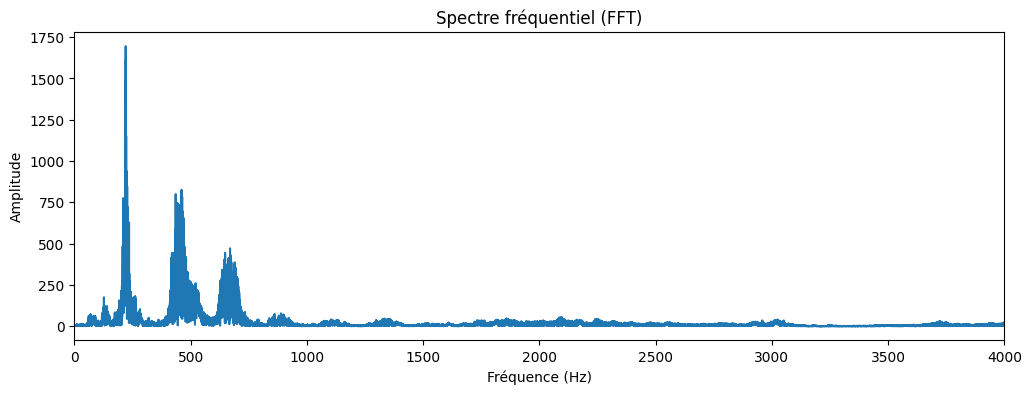

In [ ]:
from numpy.fft import fft, fftfreq

N = len(signal)
fft_signal = fft(signal)
frequences = fftfreq(N, 1/sr)

# Garder seulement fréquences positives
mask = frequences > 0
frequences = frequences[mask]
fft_magnitude = np.abs(fft_signal[mask])

plt.figure(figsize=(12,4))
plt.plot(frequences, fft_magnitude)
plt.title("Spectre fréquentiel (FFT)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, 4000)  # voix humaine < 4 kHz
plt.show()

In [ ]:
index_max = np.argmax(fft_magnitude)
pitch = frequences[index_max]
print("Fréquence fondamentale estimée :", round(pitch,2), "Hz")

Fréquence fondamentale estimée : 69.22 Hz


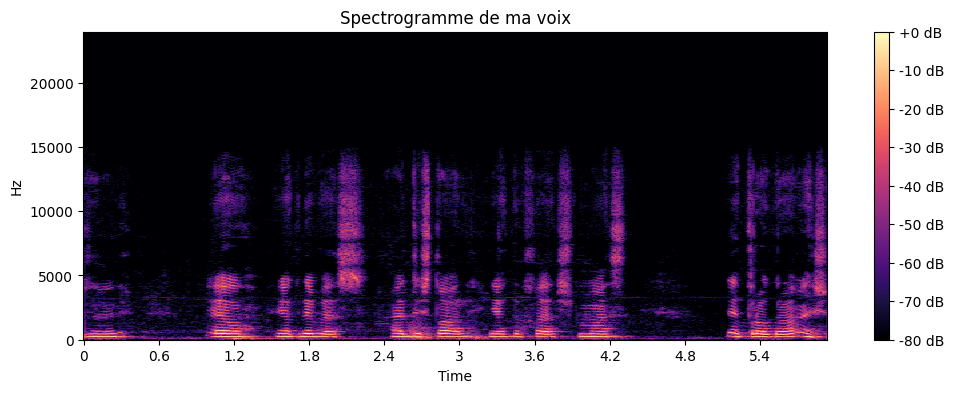

In [ ]:
import librosa.display

plt.figure(figsize=(12,4))
S = librosa.stft(signal)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogramme de ma voix")
plt.show()

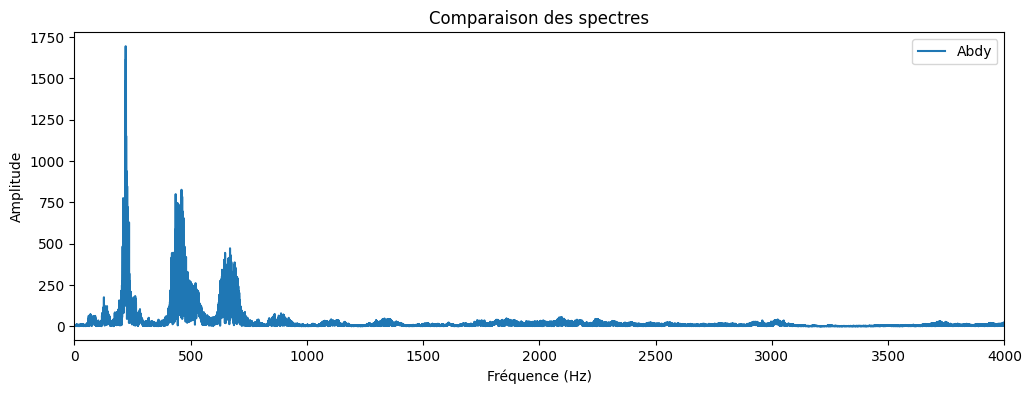

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(frequences, fft_magnitude, label="Abdy")
# plt.plot(frequences_autre, fft_magnitude_autre, label="Collègue")
plt.title("Comparaison des spectres")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0,4000)
plt.legend()
plt.show()

In [ ]:
# ===== DÉFI 5 : Déconvolution d'image =====
from skimage import data, color
from scipy.signal import convolve2d

print('🔬 DÉFI 5 — L\'Opticien Numérique (Déconvolution)')
print('-' * 55)

# Charger une image de test
image_originale = color.rgb2gray(data.astronaut()).astype(np.float64)
image_originale = image_originale[:200, :200]  # Garder une portion pour aller plus vite
image_originale /= image_originale.max()       # Normaliser 0-1

print(f'✅ Image chargée : {image_originale.shape[0]}×{image_originale.shape[1]} pixels')

# ===== Étape 1 : Modéliser le flou (PSF = Point Spread Function) =====
# Le flou de bougé directionnel = une ligne horizontale (mouvement vers la droite)

def creer_psf_mouvement(taille, angle_deg=0, longueur=15):
    """
    Crée une PSF (noyau de flou) simulant un mouvement.
    taille : taille du noyau (carré)
    angle_deg : direction du mouvement en degrés
    longueur : distance du mouvement en pixels
    """
    psf = np.zeros((taille, taille))
    centre = taille // 2
    angle_rad = np.deg2rad(angle_deg)

    for i in range(longueur):
        x = centre + int(i * np.cos(angle_rad))
        y = centre + int(i * np.sin(angle_rad))
        if 0 <= x < taille and 0 <= y < taille:
            psf[y, x] = 1

    psf /= psf.sum()  # Normaliser
    return psf

# PSF = flou de mouvement horizontal de 15 pixels
taille_psf = 31
psf = creer_psf_mouvement(taille_psf, angle_deg=0, longueur=15)

# ===== Étape 2 : Appliquer le flou (convolution) =====
image_floue = convolve2d(image_originale, psf, mode='same', boundary='wrap')

# Ajouter un petit bruit pour simuler la réalité
np.random.seed(42)
image_floue += 0.01 * np.random.randn(*image_floue.shape)

print(f'✅ Flou de mouvement appliqué (horizontal, 15 pixels)')
print(f'   Rappel : flou = convolution spatiale = multiplication dans Fourier')

🔬 DÉFI 5 — L'Opticien Numérique (Déconvolution)
-------------------------------------------------------
✅ Image chargée : 200×200 pixels
✅ Flou de mouvement appliqué (horizontal, 15 pixels)
   Rappel : flou = convolution spatiale = multiplication dans Fourier


🔧 Application du Filtre de Wiener...
✅ Déconvolution terminée !


/tmp/ipython-input-2183496304.py:62: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2183496304.py:63: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('/content/defi5_deconvolution.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


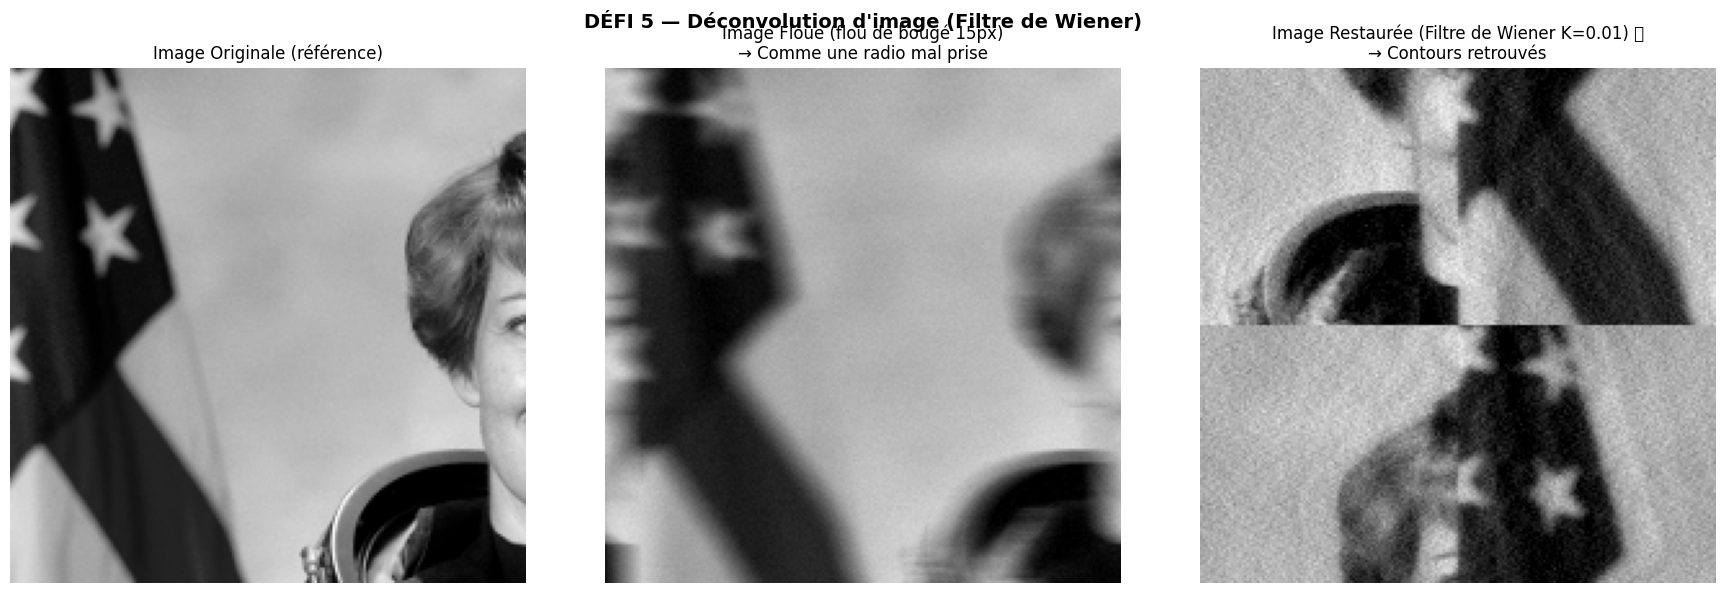

📊 Qualité de restauration :
   PSNR image floue      : 16.18 dB
   PSNR image restaurée  : 7.32 dB
   Amélioration          : +-8.87 dB
✅ Défi 5 terminé !


In [ ]:
# ===== DÉFI 5 : Filtre de Wiener pour déconvolution =====

print('🔧 Application du Filtre de Wiener...')

def filtre_wiener_2d(image_floue, psf, K=0.01):
    """
    Filtre de Wiener pour déconvolution :
    - K = paramètre de régularisation (évite l'amplification du bruit)
    - Plus K est petit, plus on essaie de retrouver le signal original
    - Plus K est grand, plus on préserve la stabilité (mais moins net)

    Formule : H_wiener = H* / (|H|² + K)
    où H = FFT de la PSF
    """
    # FFT de l'image floue et de la PSF
    IMAGE_FLOUE_FFT = np.fft.fft2(image_floue)

    # La PSF doit avoir la même taille que l'image
    psf_padded = np.zeros_like(image_floue)
    cy, cx = image_floue.shape[0]//2, image_floue.shape[1]//2
    ph, pw = psf.shape[0]//2, psf.shape[1]//2
    psf_padded[cy-ph:cy+ph+1, cx-pw:cx+pw+1] = psf

    PSF_FFT = np.fft.fft2(psf_padded)

    # Filtre de Wiener : H* / (|H|² + K)
    PSF_CONJ = np.conj(PSF_FFT)                  # Conjugué complexe
    PSF_MOD2 = np.abs(PSF_FFT) ** 2              # Module au carré
    WIENER = PSF_CONJ / (PSF_MOD2 + K)           # Filtre de Wiener

    # Application du filtre
    IMAGE_RESTAUREE_FFT = IMAGE_FLOUE_FFT * WIENER

    # Retour dans le domaine spatial
    image_restauree = np.real(np.fft.ifft2(IMAGE_RESTAUREE_FFT))

    # Clipping entre 0 et 1
    image_restauree = np.clip(image_restauree, 0, 1)

    return image_restauree

# Appliquer le filtre de Wiener
image_restauree = filtre_wiener_2d(image_floue, psf, K=0.01)
print('✅ Déconvolution terminée !')

# ===== Visualisation =====
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('DÉFI 5 — Déconvolution d\'image (Filtre de Wiener)', fontsize=14, fontweight='bold')

axes[0].imshow(image_originale, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Image Originale (référence)')
axes[0].axis('off')

axes[1].imshow(image_floue, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Image Floue (flou de bougé 15px)\n→ Comme une radio mal prise')
axes[1].axis('off')

axes[2].imshow(image_restauree, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Image Restaurée (Filtre de Wiener K=0.01) ✅\n→ Contours retrouvés')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('/content/defi5_deconvolution.png', dpi=150, bbox_inches='tight')
plt.show()

# Mesure de qualité : PSNR (Peak Signal-to-Noise Ratio)
def psnr(img1, img2):
    mse = np.mean((img1 - img2)**2)
    if mse == 0: return float('inf')
    return 10 * np.log10(1.0 / mse)

psnr_flou = psnr(image_originale, image_floue)
psnr_restaure = psnr(image_originale, image_restauree)
print(f'📊 Qualité de restauration :')
print(f'   PSNR image floue      : {psnr_flou:.2f} dB')
print(f'   PSNR image restaurée  : {psnr_restaure:.2f} dB')
print(f'   Amélioration          : +{psnr_restaure - psnr_flou:.2f} dB')
print('✅ Défi 5 terminé !')